In [2]:
%pip uninstall -y transformers

Keyring is skipped due to an exception: 'keyring.backends'
Found existing installation: transformers 4.27.0.dev1
Uninstalling transformers-4.27.0.dev1:
  Successfully uninstalled transformers-4.27.0.dev1
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -r translation/requirements.txt
%pip install -e ~/transformers/ #Or wherever you downloaded this source 

Keyring is skipped due to an exception: 'keyring.backends'
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Keyring is skipped due to an exception: 'keyring.backends'
Obtaining file:///root/transformers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Running setup.py develop for transformers
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
SRC_DIRS = [
    os.path.join('./', dirname) for dirname in [
        "text-generation",
        "text-classification",
        "token-classification",
        "language-modeling",
        "multiple-choice",
        "question-answering",
        "summarization",
        "translation",
        "image-classification",
        "speech-recognition",
        "audio-classification",
        "speech-pretraining",
        "image-pretraining",
        "semantic-segmentation",
    ]
]
sys.path.extend(SRC_DIRS)

# Comparing seeds 

In [3]:
from translation import run_translation
import argparse
import json
import logging
import os
import sys
from unittest.mock import patch

import torch

from transformers import ViTMAEForPreTraining, Wav2Vec2ForPreTraining
from transformers.testing_utils import CaptureLogger, TestCasePlus, get_gpu_count, slow, torch_device
from transformers.utils import is_apex_available
from utils import *

def get_results(output_dir):
    results = {}
    path = os.path.join(output_dir, "all_results.json")
    if os.path.exists(path):
        with open(path, "r") as f:
            results = json.load(f)
    else:
        raise ValueError(f"can't find {path}")
    return results

In [4]:
def run_translation_func(lr, seed):
    tmp_dir = get_auto_remove_tmp_dir()
    testargs = f"""
        run_translation.py
        --model_name_or_path google/long-t5-tglobal-base
        --source_lang en
        --target_lang fr
        --dataset_name news_commentary
        --dataset_config_name en-fr
        --output_dir {tmp_dir}
        --overwrite_output_dir
        --max_steps=1000
        --warmup_steps=0
        --do_train
        --learning_rate={lr}
        --per_device_train_batch_size=4
        --per_device_eval_batch_size=4
        --predict_with_generate
        --save_strategy no
        --logging_steps 10
        --lr_scheduler_type constant
        --seed {seed}
    """.split()

    with patch.object(sys, "argv", testargs):
        run_translation.main()
        result = get_results(tmp_dir)
        # print(result["eval_bleu"]>30)
    
    return tmp_dir

Grid search Lr with same fixed seed - 42

In [6]:
lrs = [1e-6,1e-6,5e-5,5e-5,1e-5,1e-5,5e-4,5e-4,1e-4,1e-4, 5e-3,5e-3, 1e-3,1e-3]

In [7]:
result_dirs_42 = []
for lr in lrs:
    result_dirs_42.append(run_translation_func(lr, 42))

03/21/2023 00:51:09 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 00:51:09 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.99,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wr

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 00:51:10,313 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 00:51:10,329 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 00:51:13 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 00:51:16,487 >> max_steps is given, it will override any value given in num_train_epochs
/root/transformers/src/transformers/optimization.py:424: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
[INFO|trainer.py:1745] 2023-03-21 00:51:16,514 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 00:51:16,515 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 00:51:16,515 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 00:51:16,516 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 00:51:16,516 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 00:51:16,517 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 00:51:16,517 >>   Total optimizatio

Step,Training Loss
10,5.946500
20,5.596700
30,5.337900
40,5.518900
50,5.487800
60,5.357100
70,5.311900
80,5.457200
90,5.625100
100,5.356200


[INFO|trainer.py:2019] 2023-03-21 00:56:18,840 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 00:56:18,882 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 00:56:18,910 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 00:56:18,911 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     4.9908
  train_runtime            = 0:05:02.32
  train_samples            =     209479
  train_samples_per_second =     13.231
  train_steps_per_second   =      3.308
03/21/2023 00:56:18 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 00:56:18 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 00:56:19,329 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 00:56:19,331 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 00:56:22 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 00:56:23,022 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 00:56:23,044 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 00:56:23,045 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 00:56:23,046 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 00:56:23,046 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 00:56:23,047 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 00:56:23,047 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 00:56:23,048 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 00:56:23,050 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 00:56:23,073 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.946500
20,5.596700
30,5.337900
40,5.518900
50,5.487800
60,5.357100
70,5.311900
80,5.457200
90,5.625100
100,5.356200


[INFO|trainer.py:2019] 2023-03-21 01:00:43,804 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:00:43,845 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:00:43,875 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:00:43,875 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     4.9908
  train_runtime            = 0:04:20.75
  train_samples            =     209479
  train_samples_per_second =      15.34
  train_steps_per_second   =      3.835
03/21/2023 01:00:43 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:00:43 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:00:44,291 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:00:44,292 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:00:46 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:00:47,119 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:00:47,139 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:00:47,140 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:00:47,140 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:00:47,141 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:00:47,141 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:00:47,142 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:00:47,142 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:00:47,144 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:00:47,158 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.530200
20,4.722600
30,4.512900
40,4.380900
50,4.260700
60,4.121900
70,4.032300
80,3.974300
90,3.987700
100,3.942000


[INFO|trainer.py:2019] 2023-03-21 01:03:42,603 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:03:42,644 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:03:42,675 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:03:42,675 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     3.3834
  train_runtime            = 0:02:55.45
  train_samples            =     209479
  train_samples_per_second =     22.797
  train_steps_per_second   =      5.699
03/21/2023 01:03:42 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:03:42 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:03:43,108 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:03:43,109 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:03:45 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:03:45,804 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:03:45,823 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:03:45,824 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:03:45,824 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:03:45,825 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:03:45,825 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:03:45,826 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:03:45,827 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:03:45,829 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:03:45,840 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.530200
20,4.722600
30,4.512900
40,4.380900
50,4.260700
60,4.121900
70,4.032300
80,3.974300
90,3.987700
100,3.942000


[INFO|trainer.py:2019] 2023-03-21 01:06:41,042 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:06:41,083 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:06:41,128 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:06:41,128 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     3.3834
  train_runtime            = 0:02:55.21
  train_samples            =     209479
  train_samples_per_second =     22.829
  train_steps_per_second   =      5.707
03/21/2023 01:06:41 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:06:41 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:06:41,554 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:06:41,556 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:06:44 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:06:44,392 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:06:44,411 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:06:44,412 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:06:44,412 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:06:44,413 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:06:44,414 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:06:44,414 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:06:44,415 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:06:44,417 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:06:44,429 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.843700
20,5.311900
30,5.028500
40,5.038900
50,4.954000
60,4.783900
70,4.727200
80,4.740000
90,4.852300
100,4.676200


[INFO|trainer.py:2019] 2023-03-21 01:09:38,703 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:09:38,745 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:09:38,777 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:09:38,777 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     3.9872
  train_runtime            = 0:02:54.28
  train_samples            =     209479
  train_samples_per_second =     22.951
  train_steps_per_second   =      5.738
03/21/2023 01:09:38 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:09:38 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:09:39,184 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:09:39,187 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:09:41 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:09:41,924 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:09:41,943 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:09:41,944 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:09:41,944 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:09:41,945 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:09:41,946 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:09:41,946 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:09:41,946 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:09:41,948 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:09:41,962 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.843700
20,5.311900
30,5.028500
40,5.038900
50,4.954000
60,4.783900
70,4.727200
80,4.740000
90,4.852300
100,4.676200


[INFO|trainer.py:2019] 2023-03-21 01:12:36,609 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:12:36,650 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:12:36,683 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:12:36,684 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     3.9872
  train_runtime            = 0:02:54.66
  train_samples            =     209479
  train_samples_per_second =     22.902
  train_steps_per_second   =      5.725
03/21/2023 01:12:36 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:12:36 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:12:37,126 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:12:37,127 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:12:39 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:12:39,868 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:12:39,887 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:12:39,888 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:12:39,888 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:12:39,889 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:12:39,889 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:12:39,889 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:12:39,890 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:12:39,892 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:12:39,906 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.735200
20,3.906900
30,3.747700
40,3.679000
50,3.553100
60,3.529000
70,3.352100
80,3.297500
90,3.421700
100,3.465600


[INFO|trainer.py:2019] 2023-03-21 01:15:34,643 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:15:34,684 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:15:34,716 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:15:34,717 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     2.8484
  train_runtime            = 0:02:54.75
  train_samples            =     209479
  train_samples_per_second =      22.89
  train_steps_per_second   =      5.722
03/21/2023 01:15:34 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:15:34 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:15:35,144 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:15:35,145 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:15:37 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:15:37,834 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:15:37,854 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:15:37,855 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:15:37,855 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:15:37,856 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:15:37,856 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:15:37,857 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:15:37,857 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:15:37,859 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:15:37,873 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.735200
20,3.906900
30,3.747700
40,3.679000
50,3.553100
60,3.529000
70,3.352100
80,3.297500
90,3.421700
100,3.465600


[INFO|trainer.py:2019] 2023-03-21 01:18:40,576 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:18:40,616 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:18:40,647 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:18:40,648 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     2.8484
  train_runtime            = 0:03:02.71
  train_samples            =     209479
  train_samples_per_second =     21.892
  train_steps_per_second   =      5.473
03/21/2023 01:18:40 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:18:40 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:18:41,057 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:18:41,058 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:18:43 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:18:43,757 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:18:43,776 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:18:43,776 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:18:43,777 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:18:43,778 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:18:43,779 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:18:43,779 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:18:43,779 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:18:43,781 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:18:43,795 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.240800
20,4.489100
30,4.251700
40,4.086100
50,3.984800
60,3.842200
70,3.711900
80,3.659400
90,3.693400
100,3.673100


[INFO|trainer.py:2019] 2023-03-21 01:21:42,062 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:21:42,099 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:21:42,130 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:21:42,131 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     3.1601
  train_runtime            = 0:02:58.28
  train_samples            =     209479
  train_samples_per_second =     22.437
  train_steps_per_second   =      5.609
03/21/2023 01:21:42 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:21:42 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:21:42,588 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:21:42,589 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:21:45 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:21:45,405 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:21:45,423 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:21:45,425 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:21:45,426 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:21:45,426 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:21:45,426 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:21:45,427 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:21:45,427 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:21:45,429 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:21:45,443 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.240800
20,4.489100
30,4.251700
40,4.086100
50,3.984800
60,3.842200
70,3.711900
80,3.659400
90,3.693400
100,3.673100


[INFO|trainer.py:2019] 2023-03-21 01:24:38,002 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:24:38,043 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:24:38,075 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:24:38,075 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     3.1601
  train_runtime            = 0:02:52.57
  train_samples            =     209479
  train_samples_per_second =     23.179
  train_steps_per_second   =      5.795
03/21/2023 01:24:38 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:24:38 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:24:38,491 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:24:38,492 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:24:41 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:24:41,302 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:24:41,322 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:24:41,322 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:24:41,323 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:24:41,323 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:24:41,324 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:24:41,324 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:24:41,324 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:24:41,326 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:24:41,340 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.510800
20,5.104400
30,4.969300
40,4.951000
50,4.858400
60,4.935900
70,4.976500
80,4.830000
90,4.968100
100,4.707900


[INFO|trainer.py:2019] 2023-03-21 01:27:35,865 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:27:35,906 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:27:35,938 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:27:35,938 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     4.2121
  train_runtime            = 0:02:54.53
  train_samples            =     209479
  train_samples_per_second =     22.918
  train_steps_per_second   =      5.729
03/21/2023 01:27:35 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:27:35 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:27:36,438 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:27:36,440 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:27:38 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:27:39,134 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:27:39,153 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:27:39,154 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:27:39,154 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:27:39,155 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:27:39,155 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:27:39,155 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:27:39,156 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:27:39,158 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:27:39,170 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.510800
20,5.104400
30,4.969300
40,4.951000
50,4.858400
60,4.935900
70,4.976500
80,4.830000
90,4.968100
100,4.707900


[INFO|trainer.py:2019] 2023-03-21 01:30:36,797 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:30:36,837 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:30:36,868 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:30:36,868 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     4.2121
  train_runtime            = 0:02:57.63
  train_samples            =     209479
  train_samples_per_second =     22.518
  train_steps_per_second   =      5.629
03/21/2023 01:30:36 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:30:36 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:30:37,319 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:30:37,320 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:30:39 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:30:40,008 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:30:40,027 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:30:40,028 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:30:40,028 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:30:40,029 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:30:40,030 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:30:40,030 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:30:40,031 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:30:40,033 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:30:40,044 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.684500
20,3.930100
30,3.831500
40,3.749200
50,3.636000
60,3.586800
70,3.405500
80,3.396100
90,3.480500
100,3.372400


[INFO|trainer.py:2019] 2023-03-21 01:33:33,927 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:33:33,968 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:33:34,000 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:33:34,000 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     2.8765
  train_runtime            = 0:02:53.89
  train_samples            =     209479
  train_samples_per_second =     23.002
  train_steps_per_second   =      5.751
03/21/2023 01:33:34 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:33:34 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:33:34,425 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:33:34,426 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:33:36 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:33:37,167 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:33:37,186 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:33:37,186 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:33:37,187 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:33:37,187 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:33:37,188 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:33:37,188 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:33:37,189 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:33:37,190 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:33:37,204 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.684500
20,3.930100
30,3.831500
40,3.749200
50,3.636000
60,3.586800
70,3.405500
80,3.396100
90,3.480500
100,3.372400


[INFO|trainer.py:2019] 2023-03-21 01:36:30,674 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:36:30,715 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     2.8765
  train_runtime            = 0:02:53.48
  train_samples            =     209479
  train_samples_per_second =     23.057
  train_steps_per_second   =      5.764


In [8]:
result_dirs_20 = []
for lr in lrs:
    result_dirs_20.append(run_translation_func(lr, 20))

[INFO|training_args.py:1509] 2023-03-21 01:36:30,755 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:36:30,756 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


03/21/2023 01:36:30 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:36:30 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.99,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wr

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:36:31,212 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:36:31,215 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:36:33 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:36:33,947 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:36:33,966 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:36:33,966 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:36:33,967 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:36:33,967 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:36:33,968 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:36:33,968 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:36:33,969 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:36:33,971 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:36:33,984 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.943500
20,5.480100
30,5.333500
40,5.714100
50,5.720600
60,5.710700
70,5.454200
80,5.361600
90,5.476600
100,5.419700


[INFO|trainer.py:2019] 2023-03-21 01:39:30,877 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:39:30,917 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:39:30,952 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:39:30,952 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =      5.009
  train_runtime            = 0:02:56.90
  train_samples            =     209479
  train_samples_per_second =     22.611
  train_steps_per_second   =      5.653
03/21/2023 01:39:30 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:39:30 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:39:31,394 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:39:31,396 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:39:33 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:39:34,152 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:39:34,171 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:39:34,172 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:39:34,173 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:39:34,173 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:39:34,174 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:39:34,174 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:39:34,175 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:39:34,177 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:39:34,188 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.943500
20,5.480100
30,5.333500
40,5.714100
50,5.720600
60,5.710700
70,5.454200
80,5.361600
90,5.476600
100,5.419700


[INFO|trainer.py:2019] 2023-03-21 01:42:41,947 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:42:41,993 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:42:42,022 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:42:42,023 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =      5.009
  train_runtime            = 0:03:07.77
  train_samples            =     209479
  train_samples_per_second =     21.303
  train_steps_per_second   =      5.326
03/21/2023 01:42:42 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:42:42 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:42:42,525 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:42:42,527 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:42:45 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:42:45,219 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:42:45,238 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:42:45,239 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:42:45,239 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:42:45,240 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:42:45,240 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:42:45,242 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:42:45,242 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:42:45,244 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:42:45,257 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.662700
20,4.804400
30,4.491200
40,4.691100
50,4.522000
60,4.326500
70,4.202100
80,4.032300
90,3.881500
100,3.725100


[INFO|trainer.py:2019] 2023-03-21 01:45:43,471 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:45:43,520 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:45:43,559 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:45:43,560 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     3.3852
  train_runtime            = 0:02:58.22
  train_samples            =     209479
  train_samples_per_second =     22.443
  train_steps_per_second   =      5.611
03/21/2023 01:45:43 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:45:43 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:45:43,978 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:45:43,979 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:45:46 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:45:46,730 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:45:46,750 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:45:46,750 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:45:46,751 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:45:46,751 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:45:46,752 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:45:46,752 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:45:46,753 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:45:46,756 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:45:46,768 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.662700
20,4.804400
30,4.491200
40,4.691100
50,4.522000
60,4.326500
70,4.202100
80,4.032300
90,3.881500
100,3.725100


[INFO|trainer.py:2019] 2023-03-21 01:48:46,302 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:48:46,345 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:48:46,376 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:48:46,376 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     3.3852
  train_runtime            = 0:02:59.54
  train_samples            =     209479
  train_samples_per_second =     22.278
  train_steps_per_second   =       5.57
03/21/2023 01:48:46 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:48:46 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:48:46,792 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:48:46,794 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:48:49 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:48:49,484 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:48:49,502 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:48:49,503 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:48:49,503 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:48:49,504 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:48:49,504 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:48:49,505 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:48:49,505 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:48:49,507 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:48:49,518 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.858900
20,5.275200
30,5.034300
40,5.185500
50,5.180200
60,5.076600
70,4.853400
80,4.744600
90,4.632100
100,4.622700


[INFO|trainer.py:2019] 2023-03-21 01:51:53,543 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:51:53,583 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:51:53,615 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:51:53,615 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     3.9919
  train_runtime            = 0:03:04.03
  train_samples            =     209479
  train_samples_per_second =     21.735
  train_steps_per_second   =      5.434
03/21/2023 01:51:53 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:51:53 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:51:54,057 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:51:54,059 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:51:56 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:51:56,798 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:51:56,818 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:51:56,818 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:51:56,819 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:51:56,819 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:51:56,820 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:51:56,821 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:51:56,822 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:51:56,824 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:51:56,838 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.858900
20,5.275200
30,5.034300
40,5.185500
50,5.180200
60,5.076600
70,4.853400
80,4.744600
90,4.632100
100,4.622700


[INFO|trainer.py:2019] 2023-03-21 01:54:50,318 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:54:50,360 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:54:50,391 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:54:50,392 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     3.9919
  train_runtime            = 0:02:53.49
  train_samples            =     209479
  train_samples_per_second =     23.055
  train_steps_per_second   =      5.764
03/21/2023 01:54:50 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:54:50 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:54:50,801 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:54:50,802 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:54:53 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:54:53,591 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:54:53,610 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:54:53,611 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:54:53,611 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:54:53,612 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:54:53,612 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:54:53,612 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:54:53,613 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:54:53,616 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:54:53,627 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.918800
20,4.035500
30,3.663600
40,3.650800
50,3.768100
60,3.605300
70,3.572400
80,3.373500
90,3.253900
100,3.109900


[INFO|trainer.py:2019] 2023-03-21 01:57:49,073 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 01:57:49,130 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 01:57:49,160 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 01:57:49,161 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     2.8307
  train_runtime            = 0:02:55.45
  train_samples            =     209479
  train_samples_per_second =     22.797
  train_steps_per_second   =      5.699
03/21/2023 01:57:49 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 01:57:49 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 01:57:49,613 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 01:57:49,614 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 01:57:52 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 01:57:52,490 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 01:57:52,509 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 01:57:52,510 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 01:57:52,510 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 01:57:52,511 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 01:57:52,511 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 01:57:52,511 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 01:57:52,512 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 01:57:52,514 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 01:57:52,527 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.918800
20,4.035500
30,3.663600
40,3.650800
50,3.768100
60,3.605300
70,3.572400
80,3.373500
90,3.253900
100,3.109900


[INFO|trainer.py:2019] 2023-03-21 02:00:45,444 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:00:45,492 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:00:45,522 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:00:45,523 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     2.8307
  train_runtime            = 0:02:52.93
  train_samples            =     209479
  train_samples_per_second =     23.131
  train_steps_per_second   =      5.783
03/21/2023 02:00:45 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:00:45 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:00:46,041 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:00:46,043 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:00:48 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:00:48,763 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:00:48,782 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:00:48,782 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:00:48,783 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:00:48,783 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:00:48,784 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:00:48,784 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:00:48,784 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:00:48,788 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:00:48,798 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.457000
20,4.521300
30,4.197200
40,4.201600
50,4.172600
60,3.956800
70,3.867300
80,3.722300
90,3.598500
100,3.461400


[INFO|trainer.py:2019] 2023-03-21 02:03:45,757 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:03:45,794 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:03:45,826 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:03:45,827 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     3.1609
  train_runtime            = 0:02:56.97
  train_samples            =     209479
  train_samples_per_second =     22.603
  train_steps_per_second   =      5.651
03/21/2023 02:03:45 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:03:45 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:03:46,292 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:03:46,294 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:03:48 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:03:49,005 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:03:49,024 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:03:49,024 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:03:49,025 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:03:49,025 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:03:49,026 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:03:49,026 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:03:49,026 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:03:49,028 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:03:49,041 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.457000
20,4.521300
30,4.197200
40,4.201600
50,4.172600
60,3.956800
70,3.867300
80,3.722300
90,3.598500
100,3.461400


[INFO|trainer.py:2019] 2023-03-21 02:06:50,242 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:06:50,281 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:06:50,313 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:06:50,314 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     3.1609
  train_runtime            = 0:03:01.21
  train_samples            =     209479
  train_samples_per_second =     22.073
  train_steps_per_second   =      5.518
03/21/2023 02:06:50 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:06:50 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:06:50,728 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:06:50,729 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:06:53 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:06:53,454 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:06:53,473 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:06:53,474 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:06:53,475 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:06:53,475 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:06:53,476 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:06:53,477 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:06:53,479 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:06:53,481 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:06:53,492 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.680500
20,5.147400
30,5.057300
40,4.967200
50,4.900100
60,4.975800
70,4.785200
80,4.586100
90,4.501200
100,4.438100


[INFO|trainer.py:2019] 2023-03-21 02:09:48,685 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:09:48,728 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:09:48,760 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:09:48,761 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     4.1783
  train_runtime            = 0:02:55.20
  train_samples            =     209479
  train_samples_per_second =     22.831
  train_steps_per_second   =      5.708
03/21/2023 02:09:48 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:09:48 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:09:49,168 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:09:49,170 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:09:51 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:09:51,897 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:09:51,917 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:09:51,917 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:09:51,918 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:09:51,918 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:09:51,918 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:09:51,919 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:09:51,919 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:09:51,921 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:09:51,934 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.680500
20,5.147400
30,5.057300
40,4.967200
50,4.900100
60,4.975800
70,4.785200
80,4.586100
90,4.501200
100,4.438100


[INFO|trainer.py:2019] 2023-03-21 02:12:49,502 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:12:49,548 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:12:49,579 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:12:49,580 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     4.1783
  train_runtime            = 0:02:57.58
  train_samples            =     209479
  train_samples_per_second =     22.525
  train_steps_per_second   =      5.631
03/21/2023 02:12:49 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:12:49 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:12:50,047 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:12:50,048 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:12:52 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:12:52,760 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:12:52,779 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:12:52,780 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:12:52,780 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:12:52,781 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:12:52,781 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:12:52,782 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:12:52,782 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:12:52,784 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:12:52,797 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.853300
20,4.175900
30,3.740200
40,3.730000
50,3.871700
60,3.719500
70,3.604100
80,3.437800
90,3.356500
100,3.142700


[INFO|trainer.py:2019] 2023-03-21 02:16:01,490 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:16:01,530 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:16:01,561 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:16:01,561 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     2.8659
  train_runtime            = 0:03:08.70
  train_samples            =     209479
  train_samples_per_second =     21.197
  train_steps_per_second   =      5.299
03/21/2023 02:16:01 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:16:01 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:16:01,981 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:16:01,982 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:16:04 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:16:04,717 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:16:04,736 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:16:04,736 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:16:04,737 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:16:04,737 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:16:04,738 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:16:04,738 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:16:04,739 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:16:04,741 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:16:04,752 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.853300
20,4.175900
30,3.740200
40,3.730000
50,3.871700
60,3.719500
70,3.604100
80,3.437800
90,3.356500
100,3.142700


[INFO|trainer.py:2019] 2023-03-21 02:19:00,596 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:19:00,640 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   259078GF
  train_loss               =     2.8659
  train_runtime            = 0:02:55.85
  train_samples            =     209479
  train_samples_per_second =     22.746
  train_steps_per_second   =      5.686


In [9]:
result_dirs_32 = []
for lr in lrs:
    result_dirs_32.append(run_translation_func(lr, 32))

[INFO|training_args.py:1509] 2023-03-21 02:19:00,679 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:19:00,680 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


03/21/2023 02:19:00 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:19:00 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
factor=0.99,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wr

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:19:01,128 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:19:01,130 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:19:03 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:19:03,842 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:19:03,861 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:19:03,862 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:19:03,862 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:19:03,863 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:19:03,863 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:19:03,864 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:19:03,864 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:19:03,866 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:19:03,877 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,6.116000
20,5.441500
30,5.776000
40,5.279700
50,5.414600
60,5.537300
70,5.674700
80,5.501800
90,5.546100
100,5.205400


[INFO|trainer.py:2019] 2023-03-21 02:21:59,371 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:21:59,414 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:21:59,445 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:21:59,446 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =       5.02
  train_runtime            = 0:02:55.50
  train_samples            =     209479
  train_samples_per_second =     22.791
  train_steps_per_second   =      5.698
03/21/2023 02:21:59 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:21:59 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:21:59,891 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:21:59,893 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:22:02 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:22:02,607 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:22:02,626 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:22:02,626 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:22:02,627 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:22:02,627 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:22:02,628 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:22:02,628 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:22:02,629 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:22:02,630 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:22:02,644 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,6.116000
20,5.441500
30,5.776000
40,5.279700
50,5.414600
60,5.537300
70,5.674700
80,5.501800
90,5.546100
100,5.205400


[INFO|trainer.py:2019] 2023-03-21 02:24:59,872 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:24:59,912 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:24:59,943 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:24:59,944 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =       5.02
  train_runtime            = 0:02:57.24
  train_samples            =     209479
  train_samples_per_second =     22.568
  train_steps_per_second   =      5.642
03/21/2023 02:24:59 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:24:59 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:25:00,354 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:25:00,356 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:25:02 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:25:03,089 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:25:03,108 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:25:03,108 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:25:03,109 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:25:03,110 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:25:03,110 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:25:03,111 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:25:03,111 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:25:03,113 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:25:03,124 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.507600
20,4.715200
30,4.687000
40,4.321800
50,4.313300
60,3.986000
70,4.033100
80,3.951600
90,3.939800
100,3.767500


[INFO|trainer.py:2019] 2023-03-21 02:27:56,760 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:27:56,801 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:27:56,833 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:27:56,834 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     3.3884
  train_runtime            = 0:02:53.64
  train_samples            =     209479
  train_samples_per_second =     23.035
  train_steps_per_second   =      5.759
03/21/2023 02:27:56 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:27:56 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:27:57,269 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:27:57,270 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:27:59 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:28:00,022 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:28:00,042 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:28:00,043 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:28:00,043 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:28:00,043 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:28:00,044 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:28:00,044 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:28:00,045 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:28:00,047 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:28:00,060 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.507600
20,4.715200
30,4.687000
40,4.321800
50,4.313300
60,3.986000
70,4.033100
80,3.951600
90,3.939800
100,3.767500


[INFO|trainer.py:2019] 2023-03-21 02:30:52,777 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:30:52,820 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:30:52,851 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:30:52,852 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     3.3884
  train_runtime            = 0:02:52.73
  train_samples            =     209479
  train_samples_per_second =     23.157
  train_steps_per_second   =      5.789
03/21/2023 02:30:52 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:30:52 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:30:53,295 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:30:53,296 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:30:55 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:30:56,028 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:30:56,047 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:30:56,047 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:30:56,047 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:30:56,048 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:30:56,048 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:30:56,049 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:30:56,049 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:30:56,051 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:30:56,064 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.983000
20,5.217800
30,5.336900
40,4.914200
50,5.010500
60,4.786100
70,4.792500
80,4.756100
90,4.757200
100,4.520500


[INFO|trainer.py:2019] 2023-03-21 02:33:55,091 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:33:55,133 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:33:55,164 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:33:55,165 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     4.0009
  train_runtime            = 0:02:59.03
  train_samples            =     209479
  train_samples_per_second =     22.341
  train_steps_per_second   =      5.585
03/21/2023 02:33:55 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:33:55 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:33:55,588 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:33:55,590 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:33:58 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:33:58,394 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:33:58,414 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:33:58,414 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:33:58,415 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:33:58,415 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:33:58,416 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:33:58,416 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:33:58,417 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:33:58,419 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:33:58,430 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.983000
20,5.217800
30,5.336900
40,4.914200
50,5.010500
60,4.786100
70,4.792500
80,4.756100
90,4.757200
100,4.520500


[INFO|trainer.py:2019] 2023-03-21 02:36:57,563 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:36:57,602 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:36:57,633 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:36:57,633 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     4.0009
  train_runtime            = 0:02:59.14
  train_samples            =     209479
  train_samples_per_second =     22.328
  train_steps_per_second   =      5.582
03/21/2023 02:36:57 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:36:57 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:36:58,059 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:36:58,061 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:37:00 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:37:00,852 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:37:00,871 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:37:00,871 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:37:00,872 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:37:00,872 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:37:00,873 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:37:00,874 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:37:00,875 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:37:00,876 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:37:00,889 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.731800
20,3.939300
30,3.802100
40,3.523900
50,3.624100
60,3.327700
70,3.465400
80,3.385100
90,3.359100
100,3.254500


[INFO|trainer.py:2019] 2023-03-21 02:39:54,173 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:39:54,211 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:39:54,240 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:39:54,240 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     2.8596
  train_runtime            = 0:02:53.29
  train_samples            =     209479
  train_samples_per_second =     23.082
  train_steps_per_second   =       5.77
03/21/2023 02:39:54 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:39:54 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:39:54,690 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:39:54,692 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:39:57 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:39:57,393 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:39:57,413 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:39:57,414 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:39:57,414 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:39:57,415 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:39:57,415 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:39:57,416 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:39:57,416 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:39:57,419 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:39:57,432 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.731800
20,3.939300
30,3.802100
40,3.523900
50,3.624100
60,3.327700
70,3.465400
80,3.385100
90,3.359100
100,3.254500


[INFO|trainer.py:2019] 2023-03-21 02:42:56,352 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:42:56,396 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:42:56,425 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:42:56,426 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     2.8596
  train_runtime            = 0:02:58.93
  train_samples            =     209479
  train_samples_per_second =     22.355
  train_steps_per_second   =      5.589
03/21/2023 02:42:56 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:42:56 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:42:56,846 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:42:56,847 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:42:59 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:42:59,659 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:42:59,677 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:42:59,678 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:42:59,679 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:42:59,679 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:42:59,680 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:42:59,680 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:42:59,681 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:42:59,682 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:42:59,695 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.217900
20,4.501600
30,4.411000
40,4.022900
50,4.032100
60,3.665300
70,3.774900
80,3.655900
90,3.664600
100,3.522200


[INFO|trainer.py:2019] 2023-03-21 02:45:55,117 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:45:55,161 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:45:55,197 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:45:55,198 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =      3.184
  train_runtime            = 0:02:55.43
  train_samples            =     209479
  train_samples_per_second =       22.8
  train_steps_per_second   =        5.7
03/21/2023 02:45:55 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:45:55 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:45:55,635 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:45:55,636 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:45:58 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:45:58,447 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:45:58,466 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:45:58,467 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:45:58,467 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:45:58,468 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:45:58,468 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:45:58,469 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:45:58,470 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:45:58,472 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:45:58,485 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.217900
20,4.501600
30,4.411000
40,4.022900
50,4.032100
60,3.665300
70,3.774900
80,3.655900
90,3.664600
100,3.522200


[INFO|trainer.py:2019] 2023-03-21 02:48:54,157 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:48:54,195 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:48:54,224 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:48:54,225 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =      3.184
  train_runtime            = 0:02:55.68
  train_samples            =     209479
  train_samples_per_second =     22.768
  train_steps_per_second   =      5.692
03/21/2023 02:48:54 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:48:54 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:48:54,666 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:48:54,668 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:48:57 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:48:57,367 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:48:57,478 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:48:57,479 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:48:57,479 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:48:57,480 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:48:57,480 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:48:57,481 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:48:57,481 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:48:57,483 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:48:57,496 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.437700
20,5.254200
30,5.114200
40,4.923300
50,4.855400
60,4.709300
70,4.728800
80,4.788000
90,4.680400
100,4.692400


[INFO|trainer.py:2019] 2023-03-21 02:51:56,952 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:51:56,994 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:51:57,025 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:51:57,026 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     4.2372
  train_runtime            = 0:02:59.46
  train_samples            =     209479
  train_samples_per_second =     22.288
  train_steps_per_second   =      5.572
03/21/2023 02:51:57 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:51:57 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:51:57,431 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:51:57,432 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:52:00 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:52:00,222 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:52:00,241 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:52:00,242 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:52:00,242 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:52:00,243 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:52:00,243 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:52:00,243 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:52:00,244 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:52:00,246 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:52:00,259 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,5.437700
20,5.254200
30,5.114200
40,4.923300
50,4.855400
60,4.709300
70,4.728800
80,4.788000
90,4.680400
100,4.692400


[INFO|trainer.py:2019] 2023-03-21 02:54:58,317 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:54:58,357 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:54:58,387 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:54:58,388 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     4.2372
  train_runtime            = 0:02:58.07
  train_samples            =     209479
  train_samples_per_second =     22.463
  train_steps_per_second   =      5.616
03/21/2023 02:54:58 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:54:58 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:54:58,891 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:54:58,893 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:55:01 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:55:01,669 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:55:01,689 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:55:01,690 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:55:01,690 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:55:01,691 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:55:01,691 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:55:01,692 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:55:01,692 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:55:01,694 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:55:01,707 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.593200
20,3.927900
30,3.824500
40,3.529600
50,3.716100
60,3.328700
70,3.450100
80,3.412000
90,3.399000
100,3.287500


[INFO|trainer.py:2019] 2023-03-21 02:57:53,882 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 02:57:53,924 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1509] 2023-03-21 02:57:53,956 >> PyTorch: setting up devices
[INFO|training_args.py:1290] 2023-03-21 02:57:53,957 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     2.8793
  train_runtime            = 0:02:52.18
  train_samples            =     209479
  train_samples_per_second =      23.23
  train_steps_per_second   =      5.808
03/21/2023 02:57:53 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/21/2023 02:57:53 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumu

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-21 02:57:54,459 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-21 02:57:54,461 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/21/2023 02:57:56 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-21 02:57:57,173 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1745] 2023-03-21 02:57:57,191 >> ***** Running training *****
[INFO|trainer.py:1746] 2023-03-21 02:57:57,192 >>   Num examples = 209479
[INFO|trainer.py:1747] 2023-03-21 02:57:57,192 >>   Num Epochs = 1
[INFO|trainer.py:1748] 2023-03-21 02:57:57,193 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1749] 2023-03-21 02:57:57,193 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1750] 2023-03-21 02:57:57,194 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1751] 2023-03-21 02:57:57,194 >>   Total optimization steps = 1000
[INFO|trainer.py:1753] 2023-03-21 02:57:57,196 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-21 02:57:57,208 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss
10,4.593200
20,3.927900
30,3.824500
40,3.529600
50,3.716100
60,3.328700
70,3.450100
80,3.412000
90,3.399000
100,3.287500


[INFO|trainer.py:2019] 2023-03-21 03:01:03,633 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-21 03:01:03,677 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248406GF
  train_loss               =     2.8793
  train_runtime            = 0:03:06.43
  train_samples            =     209479
  train_samples_per_second =     21.455
  train_steps_per_second   =      5.364


In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt


def plot_seed(result_dirs, name):
    fig = plt.figure()
    fig.set_figheight(4)
    ax = fig.add_subplot(111)
    c=0
    tflag=1
    tflaglabel=[' ','run-1 ','run-2 ']
    tcolors=[' ','ro','k-']
    offsets = [0.5]*len(result_dirs)
    offsets[-1]=-0
    offsets[-2]=-0

    for r in result_dirs:
        alllogs = json.load(open(f'{r}/trainer_state.json'))
        d1 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]
        x1 = np.array(d1)[:,0]
        y1 = np.array(d1)[:,2]
        
        tmplabel = tflaglabel[tflag] + str(lrs[c])
        
        line1, = ax.plot(x1, y1, tcolors[tflag], label=tmplabel,markersize=3)
        
        ax.annotate(lrs[c], xy=(x1[-1], y1[-1]), xytext=(x1[-1]+150, y1[-1]+offsets[c]),
            arrowprops=dict(facecolor='black',arrowstyle="->", connectionstyle="arc3"))
        
        if c==len(result_dirs)-1:
            plt.text(1100, 5.8, 'Learning \nRate')
                  
        tflag*=-1
        c+=1

    # plt.legend()
    plt.title(name)

In [4]:
%matplotlib inline

In [5]:
plot_seed(result_dirs_42, 'Seed 1 (Loss)')

NameError: name 'result_dirs_42' is not defined

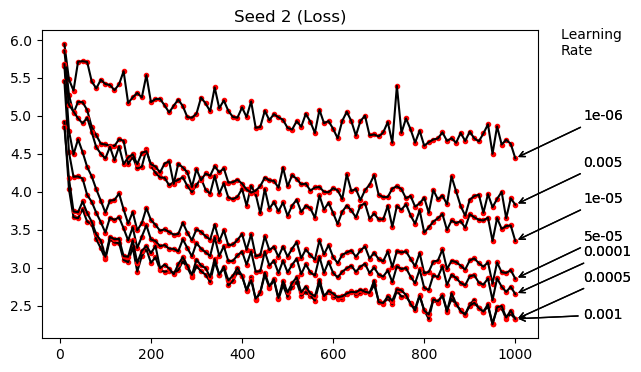

In [291]:
plot_seed(result_dirs_20, 'Seed 2 (Loss)')

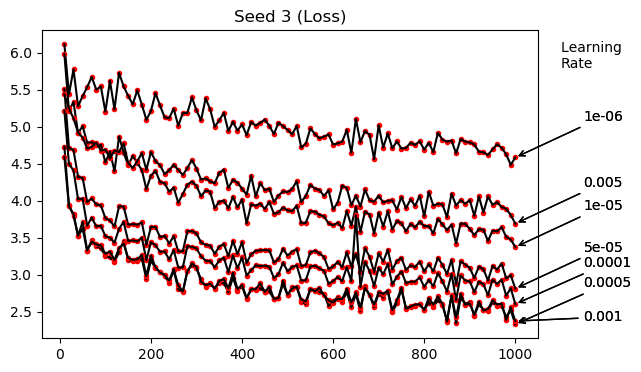

In [292]:
plot_seed(result_dirs_32, 'Seed 3 (Loss)')

# Skipping LR

In [5]:
from translation import run_translation
import argparse
import json
import logging
import os
import sys
from unittest.mock import patch

import torch

from transformers import ViTMAEForPreTraining, Wav2Vec2ForPreTraining
from transformers.testing_utils import CaptureLogger, TestCasePlus, get_gpu_count, slow, torch_device
from transformers.utils import is_apex_available
from utils import *

def get_results(output_dir):
    results = {}
    path = os.path.join(output_dir, "all_results.json")
    if os.path.exists(path):
        with open(path, "r") as f:
            results = json.load(f)
    else:
        raise ValueError(f"can't find {path}")
    return results

In [6]:
def run_translation_func_c(lr, seed:int, critical_step:int, start_LR:float, end_LR:float):

    tmp_dir = get_auto_remove_tmp_dir()
    testargs = f"""
        run_translation.py
        --model_name_or_path google/long-t5-tglobal-base
        --source_lang en
        --target_lang fr
        --dataset_name news_commentary
        --dataset_config_name en-fr
        --output_dir {tmp_dir}
        --overwrite_output_dir
        --max_steps=1000
        --warmup_steps=0
        --do_train
        --learning_rate={lr}
        --per_device_train_batch_size=4
        --per_device_eval_batch_size=4
        --predict_with_generate
        --save_strategy no
        --logging_steps 10
        --lr_scheduler_type constant_with_step
        --factor {end_LR/start_LR}
        --critical_step {critical_step}
        --seed {seed}
    """.split()
    
    print(testargs)

    with patch.object(sys, "argv", testargs):
        run_translation.main()
        result = get_results(tmp_dir)
        # print(result["eval_bleu"]>30)
    
    return tmp_dir

In [32]:
experiments = [(2000,1e-6,1e-6),
              (2000, 1e-3, 1e-3),
              (100,1e-6, 1e-3)]

In [33]:
result_dirs_42 = []
for exp in experiments:
    result_dirs_42.append(run_translation_func_c(lr=exp[1],seed=42,critical_step=exp[0],start_LR=exp[1],end_LR=exp[2]))

[INFO|training_args.py:1511] 2023-03-22 03:28:25,381 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-03-22 03:28:25,382 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


['run_translation.py', '--model_name_or_path', 'google/long-t5-tglobal-base', '--source_lang', 'en', '--target_lang', 'fr', '--dataset_name', 'news_commentary', '--dataset_config_name', 'en-fr', '--output_dir', '/tmp/tmphdw_n_iq', '--overwrite_output_dir', '--max_steps=1000', '--warmup_steps=0', '--do_train', '--learning_rate=1e-06', '--per_device_train_batch_size=4', '--per_device_eval_batch_size=4', '--predict_with_generate', '--save_strategy', 'no', '--logging_steps', '10', '--lr_scheduler_type', 'constant_with_step', '--factor', '1.0', '--critical_step', '2000', '--seed', '42']
03/22/2023 03:28:25 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
03/22/2023 03:28:25 - INFO - translation.run_translation - Training/evaluation parameters Seq2SeqTrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=Fa

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-22 03:28:25,836 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-22 03:28:25,839 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/22/2023 03:28:28 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-22 03:28:28,685 >> max_steps is given, it will override any value given in num_train_epochs
/root/transformers/src/transformers/optimization.py:460: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
[INFO|trainer.py:1758] 2023-03-22 03:28:28,705 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-03-22 03:28:28,706 >>   Num examples = 209479
[INFO|trainer.py:1760] 2023-03-22 03:28:28,706 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-03-22 03:28:28,707 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1762] 2023-03-22 03:28:28,707 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1763] 2023-03-22 03:28:28,708 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-03-22 03:28:28,708 >>   Total optimizatio

Getting constant with step scheduler: 2000.0 1.0
Constant step settings: factor=1.0 critical_step=2000.0
1.0 2000.0


Step,Training Loss
10,5.946500
20,5.596700
30,5.337900
40,5.518900
50,5.487800
60,5.357100
70,5.311900
80,5.457200
90,5.625100
100,5.356200


[INFO|trainer.py:2032] 2023-03-22 03:31:26,325 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-22 03:31:26,368 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1511] 2023-03-22 03:31:26,400 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-03-22 03:31:26,400 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     4.9908
  train_runtime            = 0:02:57.61
  train_samples            =     209479
  train_samples_per_second =     22.521
  train_steps_per_second   =       5.63
['run_translation.py', '--model_name_or_path', 'google/long-t5-tglobal-base', '--source_lang', 'en', '--target_lang', 'fr', '--dataset_name', 'news_commentary', '--dataset_config_name', 'en-fr', '--output_dir', '/tmp/tmp5yfal9u5', '--overwrite_output_dir', '--max_steps=1000', '--warmup_steps=0', '--do_train', '--learning_rate=0.001', '--per_device_train_batch_size=4', '--per_device_eval_batch_size=4', '--predict_with_generate', '--save_strategy', 'no', '--logging_steps', '10', '--lr_scheduler_type', 'constant_with_step', '--factor', '1.0', '--critical_step', '2000', '--seed', '42']
03/22/2023 03:31:26 - WARNING - translation.run_translation - Process rank: -1, device: cuda:0, n_gpu: 1d

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-22 03:31:26,838 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-22 03:31:26,840 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/22/2023 03:31:29 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-22 03:31:29,561 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-03-22 03:31:29,580 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-03-22 03:31:29,581 >>   Num examples = 209479
[INFO|trainer.py:1760] 2023-03-22 03:31:29,582 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-03-22 03:31:29,582 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1762] 2023-03-22 03:31:29,583 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1763] 2023-03-22 03:31:29,583 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-03-22 03:31:29,584 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-03-22 03:31:29,585 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-22 03:31:29,601 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Getting constant with step scheduler: 2000.0 1.0
Constant step settings: factor=1.0 critical_step=2000.0
1.0 2000.0


Step,Training Loss
10,4.684500
20,3.930100
30,3.831500
40,3.749200
50,3.636000
60,3.586800
70,3.405500
80,3.396100
90,3.480500
100,3.372400


[INFO|trainer.py:2032] 2023-03-22 03:34:30,464 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-22 03:34:30,508 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}
[INFO|training_args.py:1511] 2023-03-22 03:34:30,540 >> PyTorch: setting up devices
[INFO|training_args.py:1292] 2023-03-22 03:34:30,540 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     2.8765
  train_runtime            = 0:03:00.87
  train_samples            =     209479
  train_samples_per_second =     22.114
  train_steps_per_second   =      5.529
['run_translation.py', '--model_name_or_path', 'google/long-t5-tglobal-base', '--source_lang', 'en', '--target_lang', 'fr', '--dataset_name', 'news_commentary', '--dataset_config_name', 'en-fr', '--output_dir', '/tmp/tmpt5hta5ng', '--overwrite_output_dir', '--max_steps=1000', '--warmup_steps=0', '--do_train', '--learning_rate=1e-06', '--per_device_train_batch_size=4', '--per_device_eval_batch_size=4', '--predict_with_generate', '--save_strategy', 'no', '--logging_steps', '10', '--lr_scheduler_type', 'constant_with_step', '--factor', '1000.0000000000001', '--critical_step', '100', '--seed', '42']
03/22/2023 03:34:30 - WARNING - translation.run_translation - Process rank: -1, device: cud

  0%|          | 0/1 [00:00<?, ?it/s]

[INFO|configuration_utils.py:668] 2023-03-22 03:34:31,002 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--long-t5-tglobal-base/snapshots/aecb1376e5bd78db32ebc5c9deb257449b9e2b21/config.json
[INFO|configuration_utils.py:720] 2023-03-22 03:34:31,004 >> Model config LongT5Config {
  "_name_or_path": "google/long-t5-tglobal-base",
  "architectures": [
    "LongT5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "encoder_attention_type": "transient-global",
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "global_block_size": 16,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "local_radius": 127,
  "model_type": "longt5",
  "n_positions": 4096,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_i

03/22/2023 03:34:33 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /root/.cache/huggingface/datasets/news_commentary/en-fr/11.0.0/cfab724ce975dc2da51cdae45302389860badc88b74db8570d561ced6004f8b4/cache-d623078f28b76c49.arrow


[INFO|trainer.py:543] 2023-03-22 03:34:33,693 >> max_steps is given, it will override any value given in num_train_epochs
[INFO|trainer.py:1758] 2023-03-22 03:34:33,714 >> ***** Running training *****
[INFO|trainer.py:1759] 2023-03-22 03:34:33,714 >>   Num examples = 209479
[INFO|trainer.py:1760] 2023-03-22 03:34:33,715 >>   Num Epochs = 1
[INFO|trainer.py:1761] 2023-03-22 03:34:33,715 >>   Instantaneous batch size per device = 4
[INFO|trainer.py:1762] 2023-03-22 03:34:33,716 >>   Total train batch size (w. parallel, distributed & accumulation) = 4
[INFO|trainer.py:1763] 2023-03-22 03:34:33,716 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1764] 2023-03-22 03:34:33,717 >>   Total optimization steps = 1000
[INFO|trainer.py:1766] 2023-03-22 03:34:33,720 >>   Number of trainable parameters = 247587456
[WARNING|logging.py:280] 2023-03-22 03:34:33,734 >> You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Getting constant with step scheduler: 100.0 1000.0000000000001
Constant step settings: factor=1000.0000000000001 critical_step=100.0
1000.0000000000001 100.0


Step,Training Loss
10,5.946500
20,5.596700
30,5.337900
40,5.518900
50,5.487800
60,5.357100
70,5.311900
80,5.457200
90,5.625100
100,5.356200


[INFO|trainer.py:2032] 2023-03-22 03:37:31,399 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)


[INFO|modelcard.py:449] 2023-03-22 03:37:31,450 >> Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Translation', 'type': 'translation'}, 'dataset': {'name': 'news_commentary en-fr', 'type': 'news_commentary', 'config': 'en-fr', 'split': 'train', 'args': 'en-fr'}}


***** train metrics *****
  epoch                    =       0.02
  total_flos               =   248650GF
  train_loss               =     3.1729
  train_runtime            = 0:02:57.67
  train_samples            =     209479
  train_samples_per_second =     22.513
  train_steps_per_second   =      5.628


In [39]:
%matplotlib inline
import json
import numpy as np
import matplotlib.pyplot as plt


def plot_exps(result_dirs, name):
    fig = plt.figure()
    fig.set_figheight(4)
    ax = fig.add_subplot(111)
    c=0
    tflag=1
    tflaglabel=[' ','run-1 ','run-2 ']
    tcolors=['r-','g-','b-']
    offsets = [0, 0.25, 1]

    for r in result_dirs:
        alllogs = json.load(open(f'{r}/trainer_state.json'))
        d1 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]
        x1 = np.array(d1)[:,0]
        y1 = np.array(d1)[:,2]
        
        if experiments[c][1]==experiments[c][2]:
            tmplabel = str(experiments[c][1])
        else:
            tmplabel = f"{experiments[c][1]} -to- {experiments[c][2]}"
        
        line1, = ax.plot(x1, y1, tcolors[c], label=tmplabel,markersize=3)
        
        ax.annotate(tmplabel, xy=(x1[-1], y1[-1]), xytext=(x1[-1]+120, y1[-1]+offsets[c]),
            arrowprops=dict(facecolor='black',arrowstyle="->", connectionstyle="arc3"))
        
        
        
        if c==len(result_dirs)-1:
            plt.text(1100, 5.8, 'Learning \nRate')
                  
        tflag*=-1
        c+=1

    # plt.legend()
    plt.title(name)

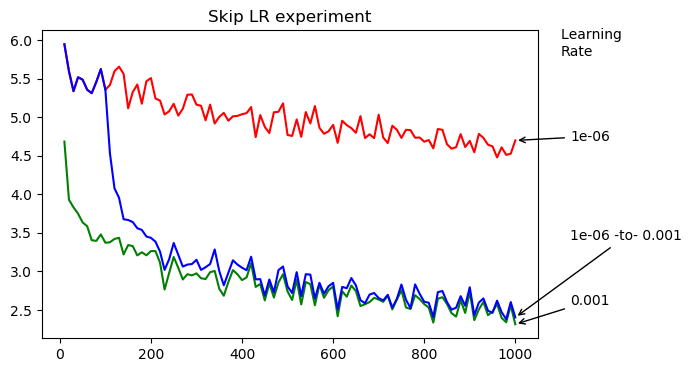

In [40]:
plot_exps(result_dirs_42, 'Skip LR experiment')

In [41]:
alllogs = json.load(open(f'{result_dirs_42[0]}/trainer_state.json'))
d1 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]

alllogs = json.load(open(f'{result_dirs_42[1]}/trainer_state.json'))
d2 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]

alllogs = json.load(open(f'{result_dirs_42[2]}/trainer_state.json'))
d3 = [ (l['step'], l['learning_rate'], l['loss']) for l in alllogs['log_history'][:-1] ]

Text(0.5, 1.0, 'LRs')

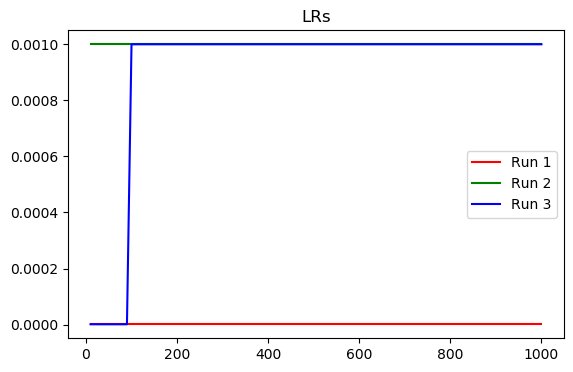

In [42]:
fig = plt.figure()
fig.set_figheight(4)
ax = fig.add_subplot(111)

x2 = np.array(d1)[:,0] 
y2 = np.array(d1)[:,1]
line1, = ax.plot(x2, y2, 'r-', label='Run 1')

x2 = np.array(d2)[:,0] 
y2 = np.array(d2)[:,1]
line1, = ax.plot(x2, y2, 'g-', label='Run 2')

x2 = np.array(d3)[:,0] 
y2 = np.array(d3)[:,1]
line1, = ax.plot(x2, y2, 'b-', label='Run 3')


plt.legend()
plt.title('LRs')

In [38]:
d2[-1][-1] - d3[-1][-1]

-0.08909999999999973